<a href="https://colab.research.google.com/github/jameswebbtc/RAVDESS_Speech_Classification/blob/main/Feature_extraction_and_Data_Augmentation_for_Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Feature Extraction & Data Augmentation for Speech Emotion Recognition**

In this notebook, Mel spectrograms are extracted from the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) dataset to be used later for building the SER model. Data augmentation is also carried out.

#**Import Necessary Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

In [ ]:
from zipfile import ZipFile
import random

In [ ]:
import librosa
import librosa.display
from IPython.display import Audio  # to play the audio files

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Preparing List of Audio Files with Labels**

In RAVEDESS dataset, there are 7,356 files (total size: 24.8 GB). The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent.

**File naming convention**

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

Filename identifiers

*  Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
*  Vocal channel (01 = speech, 02 = song).
*  Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*  Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
*  Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*  Repetition (01 = 1st repetition, 02 = 2nd repetition).
*  Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


Filename example: 02-01-06-01-02-01-12.mp4

*  Video-only (02)
*  Speech (01)
*  Fearful (06)
*  Normal intensity (01)
*  Statement "dogs" (02)
*  1st Repetition (01)
*  12th Actor (12)
*  Female, as the actor ID number is even.

**NOTE**: For this project, we will use only 'audio-only' files.

In [ ]:
# Path to dataset (zipfile)
dataset_path = '/content/drive/MyDrive/Capstone_Project/archive.zip'

# Directory to extract the contents
extracted_dir = '/content/archive'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Unzip the folder
with ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# List all contents of the extracted folder
contents = os.listdir(extracted_dir)

In [ ]:
# Filter directories starting with 'Actor_'
actor_directories = [d for d in contents if d.startswith('Actor_')]

# Create a list to store folder details
path_vec = []
label_vec = []

In [ ]:
# Store the path of a file and its label to two lists
pos_label_in_filename = 2
for d in actor_directories:
    actor_dir = os.listdir(extracted_dir + '/' + d)
    for file in actor_dir:
        tmp = file.split('.')[0]
        tmp = tmp.split('-')
        label_vec.append(int(tmp[pos_label_in_filename]))
        path_vec.append(extracted_dir + '/' + d + '/' + file)

In [ ]:
# Create a dataframe
df  = pd.DataFrame(path_vec, columns=['File_Path'])
df['Label'] = label_vec

In [ ]:
df

,File_Path,Label
0,/content/archive/Actor_08/03-01-05-01-02-01-08...,5
1,/content/archive/Actor_08/03-01-03-01-02-01-08...,3
2,/content/archive/Actor_08/03-01-04-01-01-02-08...,4
3,/content/archive/Actor_08/03-01-05-01-01-01-08...,5
4,/content/archive/Actor_08/03-01-03-02-02-01-08...,3
...,...,...
1435,/content/archive/Actor_03/03-01-02-02-02-02-03...,2
1436,/content/archive/Actor_03/03-01-08-01-01-01-03...,8
1437,/content/archive/Actor_03/03-01-01-01-01-01-03...,1
1438,/content/archive/Actor_03/03-01-07-02-02-01-03...,7


#**Making the Audio Files to Equal Time Duration**

In [ ]:
audio_duration_vec = []

for path in df['File_Path']:
  y, sr = librosa.load(path)
  duration = librosa.get_duration(y=y, sr=sr)
  audio_duration_vec.append(duration)

(array([  5.,  48.,  78., 126., 186., 235., 226., 170., 111.,  67.,  84.,
         38.,  23.,  14.,  13.,   8.,   4.,   2.,   1.,   1.]),
 array([2.93628118, 3.05306576, 3.16985034, 3.28663492, 3.4034195 ,
        3.52020408, 3.63698866, 3.75377324, 3.87055782, 3.9873424 ,
        4.10412698, 4.22091156, 4.33769615, 4.45448073, 4.57126531,
        4.68804989, 4.80483447, 4.92161905, 5.03840363, 5.15518821,
        5.27197279]),
 <BarContainer object of 20 artists>)

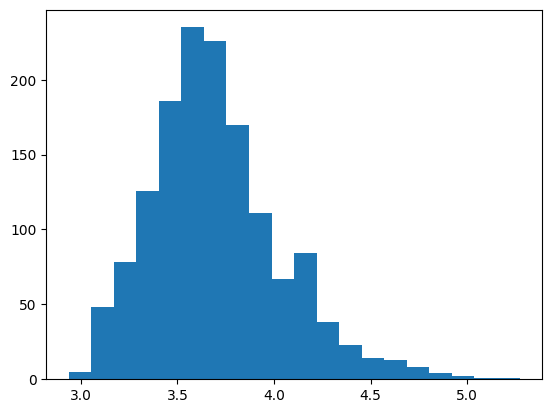

In [ ]:
plt.hist(audio_duration_vec,bins=20)

In [ ]:
# Getting the minimum and maximum duration
print('Minimum duration: ', min(audio_duration_vec), 'seconds')
print('Maximum duration: ', max(audio_duration_vec), 'seconds')

Minimum duration:  2.936281179138322 seconds
Maximum duration:  5.2719727891156465 seconds


**Inference**: The files in the dataset range from 2.93 to 5.27 seconds in duration.

Now, we have multiple options. For example,
1. Spectrograms as Inputs: We could train CNNs from the spectrograms of the audio files and resize the spectrograms to equal size
2. Time averaging : Extract features for audio file of varying duration. Then, average the values over time.
3. Inputs of fixed size without time-averaging: We could do padding of the extracted features to build models that need a fixed sized input (Ex: a feedforward neural network).

We do the first option in this notebook.

Before forming the features, let us first augment the data.

#**Data Augmentation**#

For augmenting the dataset, let us create functions to do the following steps:
1. Time Stretching and Compression:  Alter the duration of the audio by stretching or compressing time. This can change the speed of the audio without affecting its pitch.
2. Pitch Shifting:  Shift the pitch of the audio upward or downward. This can simulate variations in the pitch of the recorded sound.
3. Additive Noise : Introduce random noise to the audio signal. This can simulate background noise.
4. Resampling: Change the sampling rate of the audio signal. This can simulate variations in recording equipment or conditions
5. Random Cropping: Randomly crop a section of the audio signal.
6. Shifting in time: Shift the audio by some time. This can simulate any delays during recording.

In [ ]:
# Time Stretching and Compression
def stretch(y, rate=0.8):   #If rate > 1, then the signal is sped up. If rate < 1, then the signal is slowed down.
    return librosa.effects.time_stretch(y=y, rate=rate)

In [ ]:
# Pitch Shifting
# Note: 'librosa.effects.pitch_shift' shifts the pitch of a waveform by 'n_steps' steps.
# A step is equal to a semitone if bins_per_octave is set to 12 (https://librosa.org/doc/latest/generated/librosa.effects.pitch_shift.html)
def pitch(y, sr, n_steps=4):
    return librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

In [ ]:
# Additive Noise
def noise(y, fac=0.035):
    noise_amp = fac*np.random.uniform()*np.amax(y)
    y = y + noise_amp*np.random.normal(size=y.shape[0])
    return y

In [ ]:
# Resampling
def resample(y, sr, target_sr=22050):
  y_resampled = librosa.resample(y=y, orig_sr=sr, target_sr=target_sr)
  return y_resampled

In [ ]:
# Random Cropping
def random_crop(y, sr, crop_duration=2.0):
  original_duration = librosa.get_duration(y=y, sr=sr)
  # Randomly choose the starting point for cropping
  start_time = np.random.uniform(0, original_duration - crop_duration)
  # Extract the randomly cropped segment
  y_cropped = y[int(start_time * sr):int((start_time + crop_duration) * sr)]
  return y_cropped

In [ ]:
# Shifting in Time
def shift(y, sr, time_shift=1.0):
  samples_to_shift = int(time_shift * sr)
  # Perform time shift by introducing a delay
  #y_shifted = np.roll(y, samples_to_shift)
  if time_shift >= 0:
    y_shifted = np.concatenate([np.zeros(samples_to_shift), y])
  else:
    y_shifted = np.concatenate([y,np.zeros(-samples_to_shift)])
  return y_shifted

##Checking the Functions on a Sample File

In [ ]:
# Original Audio
path              = df['File_Path'].iloc[210]
y, sr             = librosa.load(path)
Audio(path)

In [ ]:
# Stretched audio
y_stretched =  stretch(y, rate=0.8)
Audio(y_stretched, rate=sr)

In [ ]:
# Pitch Shifting
y_pitch_shifted =  pitch(y, sr, n_steps=3)
Audio(y_pitch_shifted, rate=sr)

In [ ]:
# Adding Noise
y_noise_added =  noise(y, fac=0.04)
Audio(y_noise_added, rate=sr)

In [ ]:
# Resampling
target_sr     = 10000
y_resampled =  resample(y, sr, target_sr=target_sr)
Audio(y_resampled, rate=target_sr)

In [ ]:
# Random Cropping
y_cropped =  random_crop(y, sr, crop_duration=1.8)
Audio(y_cropped, rate=sr)

In [ ]:
# Shifting in Time
y_time_shifted =  shift(y, sr, time_shift=-2.2)
Audio(y_time_shifted, rate=sr)

Thus, all the functions for data augmentation have been validated.

##**Function to return modified audio**

Though we have 6 different augmentation operations ready, after experimenting with the inputs, we decided to use only 'stretching of audio', 'shifting pitch' and 'adding noise' for data aumgnetation.

In [ ]:
from inspect import EndOfBlock
def modify_audio(y, sr):
  # Select the modification operations randomly.
  # For this we create an array of 6 elements that take values of 0 or 1
  # Each position in the array indicate a modification method like stretching, pitch shifting etc. If the value at a position is 1, that operation is carried out
  decision_ar = np.random.randint(2, size=6)

  # Modify the audio data
  y_mod     = y
  if decision_ar[0]==1:   # Stretching in time has to be carried out
    rate  =  random.uniform(0.8, 1.2)
    y_mod =  stretch(y, rate=rate)

  if decision_ar[1]==1:   # Pitch shifting has to be carried out
    n_steps  =  random.randint(1,3)
    y_mod =  pitch(y_mod, sr, n_steps=n_steps)

  if decision_ar[2]==1:   # Noise has to be added
    fac  =  random.uniform(0.01, 0.04)
    y_mod = noise(y_mod, fac=fac)

  #if decision_ar[3]==1:   # Resampling has to be carried out
  #  target_sr=10000
  #  y_mod =  resample(y_mod, sr, target_sr=target_sr)
  #  y_mod =  resample(y_mod, target_sr, target_sr=sr)

  #if decision_ar[4]==1:   # Random cropping has to be carried out
  #  crop_duration  =  random.uniform(0.05, 0.1)
  #  y_mod = random_crop(y_mod, sr, crop_duration=crop_duration)

  #if decision_ar[5]==1:   # Shifting in time has to be carried out
  #  time_shift  =  random.uniform(-0.1, -0.8)
  #  y_mod =  shift(y_mod, sr, time_shift=time_shift)

  #print(decision_ar)
  return y_mod



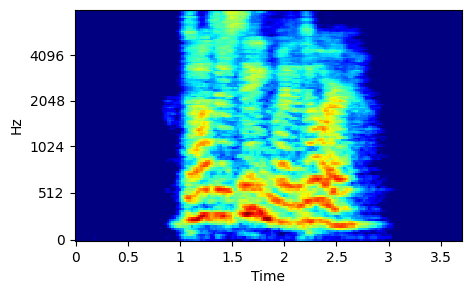

In [ ]:
y_mod = modify_audio(y, sr)

S = librosa.feature.melspectrogram(y=y_mod, sr=sr, n_mels=128, fmax=8000)
D = librosa.power_to_db(S, ref=np.max)

fig, ax = plt.subplots(figsize=(5, 3))
# Update the data for the existing figure
ax.clear()
librosa.display.specshow(D, x_axis='time', y_axis='mel', sr=sr, hop_length=512, fmax=8000, cmap='jet')
Audio(y_mod, rate=sr)


In [ ]:
# Flag to indicate if data augmentation is required
is_data_augm = 1
if is_data_augm == 0:
  n_data_augm   = 0
else:
  n_data_augm   = 9  # Add these many modified files

#**Input Type 1: Mel Spectrograms**

In [ ]:
# Output folder path
if is_data_augm == 0:
  out_folder_path = '/content/drive/MyDrive/Capstone_Project/Spectrogram_inputs'
  # Remove existing data in the output folder
  !rm /content/drive/MyDrive/Capstone_Project/Spectrogram_inputs/*
else:
  out_folder_path = '/content/drive/MyDrive/Capstone_Project/Spectrogram_inputs_with_data_augm'
  # Remove existing data in the output folder
  !rm /content/drive/MyDrive/Capstone_Project/Spectrogram_inputs_with_data_augm/train/*
  !rm /content/drive/MyDrive/Capstone_Project/Spectrogram_inputs_with_data_augm/val/*
  !rm /content/drive/MyDrive/Capstone_Project/Spectrogram_inputs_with_data_augm/test/*

rm: cannot remove '/content/drive/MyDrive/Capstone_Project/Spectrogram_inputs_with_data_augm/train/*': No such file or directory
rm: cannot remove '/content/drive/MyDrive/Capstone_Project/Spectrogram_inputs_with_data_augm/val/*': No such file or directory


##**Splitting to training, validation and test datasets**

In [ ]:
# Shuffle the rows
tmp_df= df.sample(frac=1)
tmp_df.head(2)

,File_Path,Label
1388,/content/archive/Actor_03/03-01-03-02-02-01-03...,3
381,/content/archive/Actor_05/03-01-02-01-02-02-05...,2


In [ ]:
# Split the dataset into training, validation and test sets
train_data, test_data = train_test_split(tmp_df, test_size=0.2, random_state=42, stratify=tmp_df['Label'])
train_data, val_data  = train_test_split(train_data, test_size=0.2, random_state=42,stratify=train_data['Label'])

In [ ]:
train_data.shape

(921, 2)

In [ ]:
test_data.shape

(288, 2)

In [ ]:
val_data.shape

(231, 2)

In [ ]:
tmp_df.shape

(1440, 2)

##**Function to Generate Mel Spectrograms with or without Data Augmentation**

In [ ]:
# Function to perform data augmentation
def generate_mel_spectrogram( df, n_data_augm, out_folder_path):
  iter = 0
  iter_actual_file = 0

  # Create a figure outside the loop
  fig, ax = plt.subplots(figsize=(10, 6))

  # Loop
  for filepath in df['File_Path']:
    label     = df['Label'].iloc[iter_actual_file]
    data, sampling_rate = librosa.load(filepath)
    if label==0:
      n_data_augm_tmp = n_data_augm * 2   # To account for class imbalance in 'neutral' class
    else:
      n_data_augm_tmp = n_data_augm

    for iter_augm in range(0, n_data_augm_tmp+1):
      outfile   = out_folder_path + '/Mel_spectrogram_pic_' + str(iter) + '_label_' + str(label) + '.png'
      if iter_augm == 0:
        data_mod  = data
      else:
        data_mod  = modify_audio(data, sampling_rate)
      S = librosa.feature.melspectrogram(y=data_mod, sr=sampling_rate, n_mels=128, fmax=8000)
      D = librosa.power_to_db(S, ref=np.max)

      # Update the data for the existing figure
      ax.clear()
      librosa.display.specshow(D, x_axis='time', y_axis='mel', sr=sampling_rate, hop_length=512, fmax=8000, cmap='jet')
      ax.axis('off')  # Turn off axis labels

      # Save the updated figure as an image
      fig.savefig(outfile, bbox_inches='tight', pad_inches=0)
      iter = iter+1
      del S, D, data_mod
    iter_actual_file = iter_actual_file + 1
    print(iter_actual_file)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


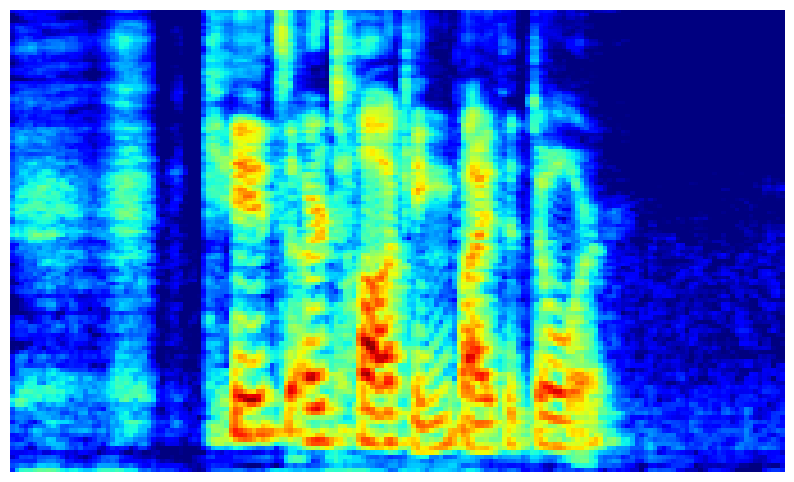

In [ ]:
generate_mel_spectrogram( test_data, 0, out_folder_path+'/test')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231


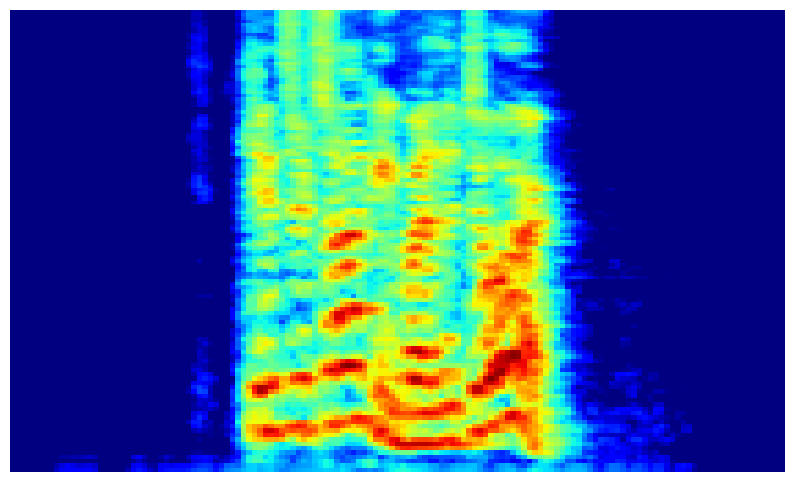

In [ ]:
generate_mel_spectrogram( val_data, n_data_augm, out_folder_path+'/val')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


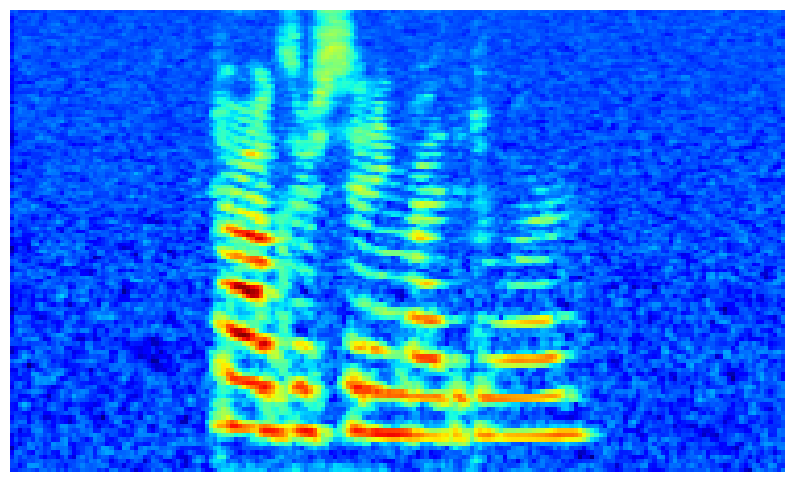

In [ ]:
generate_mel_spectrogram( train_data, n_data_augm, out_folder_path+'/train')